CIFAR-10 classification with k-NN
---

> **Exercise**: Load the data from the `c4_cifar10-6k.npz` file into X/y arrays. The data type of the input matrix `X` should be `float64`. Split it into train (5,000 images) and test (1,000) sets using the `train_test_split()` function. Set the `random_state` to zero. 

In [1]:
import numpy as np
import os

# Load the .npz file
with np.load("c4_cifar10-6k.npz", allow_pickle=False) as data:
    cifar10_data = dict(data.items())

print("Data loaded")
print("It is a dictionary with keys:", list(cifar10_data.keys()))

Data loaded
It is a dictionary with keys: ['data', 'labels', 'names']


In [2]:
# Create X/y arrays
X = cifar10_data["data"]
y = cifar10_data["labels"]
names = cifar10_data["names"]

print("X:", X.shape, X.dtype)
print("y:", y.shape, y.dtype)
print("names:", names)

X: (6000, 3072) uint8
y: (6000,) int32
names: ['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']


In [3]:
from sklearn.model_selection import train_test_split

# Convert the type of the input matrix to float
X = X.astype(np.float)

# Split data into train/test sets
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, train_size=5000, test_size=1000, random_state=0
)

Solution: Data exploration
---

The ten categories are numerically encoded with digits between 0 and 9.

| digit | category   | digit | category   |
|-------|------------|-------|------------|
| 0     | airplane   | 5     | dog        |
| 1     | automobile | 6     | frog       |
| 2     | bird       | 7     | horse      |
| 3     | cat        | 8     | ship       |
| 4     | deer       | 9     | truck      |

> **Exercise**: What is the proportion of images in each category? Plot a few images from the dataset.

In [4]:
import pandas as pd

# Image distribution
pd.value_counts(y, normalize=True)

8    0.103333
2    0.103167
6    0.102667
9    0.102167
4    0.101833
0    0.101667
7    0.099500
5    0.097167
3    0.096667
1    0.091833
dtype: float64

Label: 5 (dog)


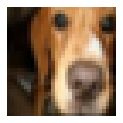

Label: 3 (cat)


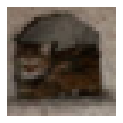

Label: 6 (frog)


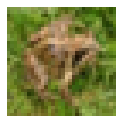

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

# Function to plot the i-th image from some X/y arrays
def show_image(idx, X, y):
    # Print its label
    label = y[idx]
    print("Label: {} ({})".format(label, names[label]))  # Class name

    # Get image pixels
    flat_img = X[idx]  # has shape (3072,)

    # Reshape the "flat vector" into a 32x32x3 array
    img = flat_img.reshape(32, 32, 3)

    # The imshow() function expects pixel values
    # between 0 and 1 when the data type is float.
    img = img / 255  # Rescale [0,255] values to [0,1]

    # Plot the image
    plt.figure(figsize=(2, 2))  # 2 by 2 figure (in inches)
    plt.imshow(img)
    plt.axis("off")  # Hide the x- and y-axis
    plt.show()


# Show the first images from the training set
show_image(0, X_tr, y_tr)
show_image(1, X_tr, y_tr)
show_image(2, X_tr, y_tr)

Solution: Fit a *k*-NN classifier
---

> **Exercise**: Create a *k*-NN classifer and tune it using grid search for the following hyperparameters.
> 1. The number of neighbors: define a set of reasonable values
> 1. The weighting function: "uniform" or "distance"
> 1. The distance metric: L1 or L2

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Create k-NN classifier
pipe = Pipeline(
    [
        # ('scaler', StandardScaler()), # With standardization
        ("scaler", None),  # Better performance without standardization!
        (
            "knn",
            KNeighborsClassifier(
                algorithm="brute",  # Brute-force search
                n_jobs=-1,  # As many parallel jobs as possible
            ),
        ),
    ]
)

In [7]:
from sklearn.model_selection import ParameterGrid

# A first grid of parameters - start with a few k values
grid = ParameterGrid(
    {
        "knn__n_neighbors": [10, 20, 30],  # k
        "knn__weights": ["uniform", "distance"],  # Weighting function
        "knn__p": [1, 2],  # L1 and L2 distance metrics
    }
)

# Print the number of combinations
print("Number of combinations:", len(grid))

Number of combinations: 12


In [8]:
# Save accuracy on test set
test_scores = []

# Enumerate combinations starting from 1
for i, params_dict in enumerate(grid, 1):
    # Print progress
    print("Combination {}/{}".format(i, len(grid)))  # Total number of combinations

    # Set parameters
    pipe.set_params(**params_dict)

    # Fit a k-NN classifier
    pipe.fit(X_tr, y_tr)

    # Save accuracy on test set
    params_dict["accuracy"] = pipe.score(X_te, y_te)

    # Save result
    test_scores.append(params_dict)

print("done")

Combination 1/12
Combination 2/12
Combination 3/12
Combination 4/12
Combination 5/12
Combination 6/12
Combination 7/12
Combination 8/12
Combination 9/12
Combination 10/12
Combination 11/12
Combination 12/12
done


In [9]:
# Create DataFrame with test scores
scores_df = pd.DataFrame(test_scores)

# Print scores
scores_df.sort_values(by="accuracy", ascending=False)

,knn__n_neighbors,knn__p,knn__weights,accuracy
1,10,1,distance,0.338
0,10,1,uniform,0.320
9,30,1,distance,0.319
5,20,1,distance,0.318
8,30,1,uniform,0.310
4,20,1,uniform,0.307
3,10,2,distance,0.304
11,30,2,distance,0.303
10,30,2,uniform,0.301
7,20,2,distance,0.292


In [10]:
# Refine our search
pipe = Pipeline(
    [
        ("scaler", None),  # Again, without standardization
        (
            "knn",
            KNeighborsClassifier(
                algorithm="brute",  # Brute-force search
                p=1,  # L1 distance seems better than L2
                weights="distance",  # Distance function seems better than uniform
                n_jobs=-1,  # As many parallel jobs as possible
            ),
        ),
    ]
)

# Refine the grid
grid = ParameterGrid({"knn__n_neighbors": [1, 5, 10, 15, 20]})  # Best k seems around 10

# Grid search
test_scores = []

for i, params_dict in enumerate(grid, 1):
    # Print progress
    print("Combination {}/{}".format(i, len(grid)))  # Total number of combinations

    # Set parameters
    pipe.set_params(**params_dict)

    # Fit a k-NN classifier
    pipe.fit(X_tr, y_tr)

    # Save accuracy on test set
    params_dict["accuracy"] = pipe.score(X_te, y_te)

    # Save result
    test_scores.append(params_dict)

print("done")

Combination 1/5
Combination 2/5
Combination 3/5
Combination 4/5
Combination 5/5
done


In [11]:
# Create DataFrame with scores
pd.DataFrame(test_scores).sort_values(by="accuracy", ascending=False)

,knn__n_neighbors,accuracy
2,10,0.338
3,15,0.328
1,5,0.321
4,20,0.318
0,1,0.301
